In [ ]:
## This Cell is related to date preprocessing and is completely copied from original kipf's github code!

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as sp
import torch,torch.nn,torch.sparse,torch.nn.functional,torch.distributions
from sklearn.metrics import roc_auc_score,average_precision_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
np.set_printoptions(threshold=np.inf)


from google.colab import drive
drive.mount('/content/drive')


W_gene      =  pd.read_table( "/content/drive/My Drive/Data Fusion/GBM_Adjacency_matrices/gene.txt", delim_whitespace=True).to_numpy()
W_methy     =  pd.read_table( "/content/drive/My Drive/Data Fusion/GBM_Adjacency_matrices/methy.txt", delim_whitespace=True).to_numpy()
W_mirna     =  pd.read_table( "/content/drive/My Drive/Data Fusion/GBM_Adjacency_matrices/mirna.txt", delim_whitespace=True).to_numpy()
W_fused     =  pd.read_table( "/content/drive/My Drive/Data Fusion/GBM_Adjacency_matrices/W_fused.txt", delim_whitespace=True).to_numpy()

W_gene  =  np.array(ro.r['W_gene'])
W_methy =  np.array(ro.r['W_methy'])
W_mirna =  np.array(ro.r['W_mirna'])

gene      =  pd.read_table( "/content/drive/My Drive/Data Fusion/GBM/GLIO_Gene_Expression.txt", delim_whitespace=True).to_numpy().transpose()
methy     =  pd.read_table( "/content/drive/My Drive/Data Fusion/GBM/GLIO_Methy_Expression.txt", delim_whitespace=True).to_numpy().transpose()
mirna     =  pd.read_table( "/content/drive/My Drive/Data Fusion/GBM/GLIO_Mirna_Expression.txt", delim_whitespace=True).to_numpy().transpose()
truelabel =  pd.read_table( "/content/drive/My Drive/Data Fusion/GBM/GLIO_Survival.txt", delim_whitespace=True).to_numpy()



print(gene.shape)
print(methy.shape)
print(mirna.shape)

def get_nomralized_laplacian(a):
    no = a.shape[0]
    b = np.diag(np.power(1.0 / a.sum(axis=1), 0.5))
    res = (b @ a @ b)
    #res[range(a.shape[0]),range(a.shape[0])]*=3
    return res




%load_ext rpy2.ipython





Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.


(215, 12042)
(215, 1305)
(215, 534)
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.


In [ ]:
#Model definition Cell


cluster_num = 5
emb_dim = 10



class Model(torch.nn.Module):

    def __init__(self,optimizer_type,A_tilda_gene,A_tilda_methy,A_tilda_mirna,**kwargs):
        super(Model, self).__init__(**kwargs)
        
        
        

        self.L_layer = torch.nn.Linear(cluster_num,215,bias=False)


        ###########################

        
            

        self.W0 = torch.nn.Linear(215,emb_dim)
        self.W1 = torch.nn.Linear(emb_dim,215)
       
        self.attn_gene = torch.nn.Linear(215,1)
        self.attn_methy = torch.nn.Linear(215,1)
        self.attn_mirna = torch.nn.Linear(215,1)
        
        param_list = []
        param_list += list(self.W0.parameters())
        param_list += list(self.W1.parameters())
        param_list += list(self.attn_gene.parameters())
        param_list += list(self.attn_methy.parameters())
        param_list += list(self.attn_mirna.parameters())
        param_list += list(self.L_layer.parameters())
        
        self.A_tilda_gene = A_tilda_gene
        self.A_tilda_methy = A_tilda_methy
        self.A_tilda_mirna = A_tilda_mirna

        
        if optimizer_type == 'adam':
          self.optimizer = torch.optim.Adam(param_list,lr=0.01)
        elif optimizer_type=='lbfgs':
          self.optimizer = torch.optim.LBFGS(param_list,lr=0.01,max_iter=20)
        self.recon = None
        
        self.normal_dist = torch.distributions.MultivariateNormal(loc=torch.zeros(emb_dim),scale_tril=torch.eye(emb_dim))
        #torch.distributions.Trun
        
        
        
    


        
    def forward(self,x) : 
        
        self.g_prim_gene =  self.attn_gene(x).view(-1,1)
        self.g_prim_methy =  self.attn_methy(x).view(-1,1)
        self.g_prim_mirna =  self.attn_mirna(x).view(-1,1)
        self.g_prim = torch.cat([self.g_prim_gene,self.g_prim_methy,self.g_prim_mirna],1)
        self.g = torch.nn.functional.softmax(self.g_prim,dim=1)
        self.g_gene = self.g[:,0].view(-1)
        self.g_methy = self.g[:,1].view(-1)
        self.g_mirna = self.g[:,2].view(-1)

         
        #self.view_hat  = torch.diag(self.g_gene) @ self.A_tilda_gene @ torch.diag(self.g_gene)  +  torch.diag(self.g_methy) @ self.A_tilda_methy @ torch.diag(self.g_methy)   +    torch.diag(self.g_mirna) @ self.A_tilda_mirna @ torch.diag(self.g_mirna)
        self.view_hat  =  self.A_tilda_gene

        #self.A_tilda_hat = 0.1 * torch.Tensor(np.identity(215)) + self.view_hat
        #self.A_tilda_hat = 1 * torch.Tensor(np.identity(215))*self.view_hat +1* self.view_hat
        self.A_tilda_hat = 0*torch.Tensor(np.identity(215)) +1* self.view_hat



        
        
       
        #self.layer_1 = torch.nn.functional.relu(self.A_tilda_hat @ self.W0(x))+ 0.001 * torch.abs(self.normal_dist.sample((x.shape[0],)))
        self.layer_1 = torch.nn.functional.relu(self.A_tilda_hat @ self.W0(x))
        #self.layer_1 = torch.nn.functional.softmax(self.A_tilda_hat @ self.W0(x),1)

        self.layer_2 = torch.nn.functional.softmax(self.A_tilda_hat @ self.W1(self.layer_1),1)
        #self.layer_2 = torch.nn.functional.relu(self.A_tilda_hat @ self.W1(self.layer_1))


        self.x_prim = self.layer_2
        self.embedding = self.layer_1
        
        self.recon_loss = torch.nn.functional.cross_entropy(self.x_prim, target=torch.nonzero(x)[:,1],reduction='mean')
        #self.recon_loss = (torch.abs(self.x_prim-x)).mean()
        #self.recon_loss = (torch.abs(self.x_prim-x)**2).mean()
        self.fair_attention_loss = self.g_gene.mean()*torch.log(self.g_gene.mean()) + self.g_methy.mean()*torch.log(self.g_methy.mean()) + self.g_mirna.mean()*torch.log(self.g_mirna.mean()) 
        self.L = self.L_layer(torch.Tensor(np.identity(cluster_num)))
        self.clustering_loss = torch.trace( self.L @ self.A_tilda_hat @ self.L.transpose(0,1) )
        self.ortho_L_loss = self.L @ self.L.transpose(0,1) - torch.Tensor(np.identity(cluster_num)) 
        #self.ortho_L_loss = (self.ortho_L_loss**2).mean()
        self.ortho_L_loss = (torch.abs(self.ortho_L_loss)).mean()

        self.L1_on_view_hat  = torch.abs(self.view_hat).mean()
        
        
        #self.loss = self.recon_loss + 0.001 * self.fair_attention_loss + 0.1 * self.ortho_L_loss + 0.1* self.clustering_loss + 0.01*(self.layer_1**2).mean(1).mean(0)
        
        #self.loss = self.recon_loss + 0.01* self.fair_attention_loss+ 0.001*(self.layer_1**2).mean()+1*self.L1_on_view_hat
        self.loss = self.recon_loss + 0.01* self.fair_attention_loss+ 0*(self.layer_1**2).mean()+0*self.L1_on_view_hat

        #self.loss = self.recon_loss + 0.01* self.fair_attention_loss
        #self.loss = self.recon_loss +  0.001*(self.layer_1**2).mean(1).mean(0)
        #self.loss = self.L.data.sum()
        #self.l1_regularization =  (torch.norm(list(self.W0.parameters())[0],1))+(torch.norm(list(self.W1.parameters())[0],1))
        #self.KL_loss = (self.embedding**2).mean(1).mean(0)
        #self.loss = self.recon_loss+self.KL_loss/50+self.l1_regularization/1000000
       
        
        
        
        
        
        return self.loss.item(),self.recon_loss.item(),self.fair_attention_loss.item(),self.ortho_L_loss.item(),self.clustering_loss,self.L1_on_view_hat
        
    def backprop(self) :
        
        self.optimizer.zero_grad()
        self.loss.backward()
        self.optimizer.step()

        
    def backprop2(self,x):
      def closure():
        self.optimizer.zero_grad()
        self.forward(x)
        self.loss.backward()
        return self.loss
      self.optimizer.step(closure)    
    
      


Epoch: 0001 train_loss= 5.35964 recon_loss= 5.37062 fair_attention_loss= -1.09859 ortho_L_loss= 3.13341 clustering_loss= 5.96231 L1_on_view_hat= 0.00443


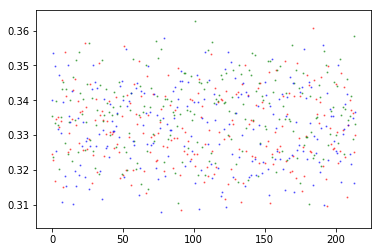

group_sc_A_tilda
 1  2  3 
86 35 94 


   pvalue 
0.8469429 


@@@@@@


group_sc_emb
  1   2   3 
139   5  71 


     pvalue 
0.001565382 


@@@@@@@@@@@@
###############################################
Epoch: 0101 train_loss= 5.30993 recon_loss= 5.32092 fair_attention_loss= -1.09861 ortho_L_loss= 3.13341 clustering_loss= 5.96231 L1_on_view_hat= 0.00443


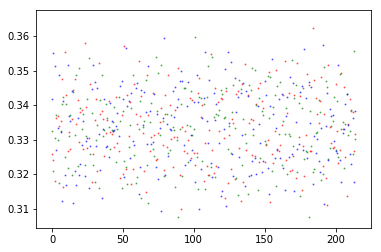

group_sc_A_tilda
 1  2  3 
86 35 94 


   pvalue 
0.8469429 


@@@@@@


group_sc_emb
  1   2   3 
 24 137  54 


      pvalue 
0.0004413695 


@@@@@@@@@@@@
###############################################
Epoch: 0201 train_loss= 5.25627 recon_loss= 5.26726 fair_attention_loss= -1.09861 ortho_L_loss= 3.13341 clustering_loss= 5.96231 L1_on_view_hat= 0.00443


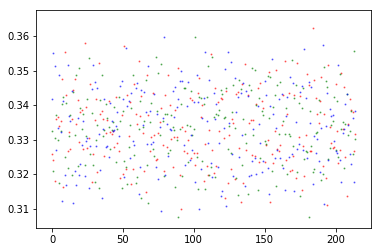

group_sc_A_tilda
 1  2  3 
86 35 94 


   pvalue 
0.8469429 


@@@@@@


group_sc_emb
  1   2   3 
 36 131  48 


     pvalue 
0.001495134 


@@@@@@@@@@@@
###############################################
Epoch: 0301 train_loss= 5.21334 recon_loss= 5.22432 fair_attention_loss= -1.09861 ortho_L_loss= 3.13341 clustering_loss= 5.96231 L1_on_view_hat= 0.00443


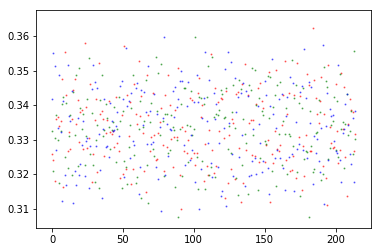

group_sc_A_tilda
 1  2  3 
86 35 94 


   pvalue 
0.8469429 


@@@@@@


group_sc_emb
  1   2   3 
 54 125  36 


      pvalue 
0.0002563868 


@@@@@@@@@@@@
###############################################
Epoch: 0401 train_loss= 5.19278 recon_loss= 5.20376 fair_attention_loss= -1.09861 ortho_L_loss= 3.13341 clustering_loss= 5.96231 L1_on_view_hat= 0.00443


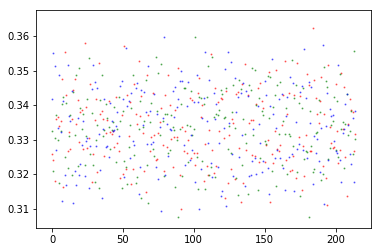

group_sc_A_tilda
 1  2  3 
86 35 94 


   pvalue 
0.8469429 


@@@@@@


group_sc_emb
  1   2   3 
 42  24 149 


    pvalue 
0.01066951 


@@@@@@@@@@@@
###############################################
Epoch: 0501 train_loss= 5.18726 recon_loss= 5.19825 fair_attention_loss= -1.09861 ortho_L_loss= 3.13341 clustering_loss= 5.96231 L1_on_view_hat= 0.00443


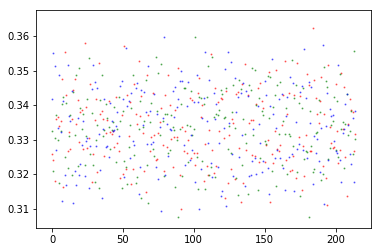

group_sc_A_tilda
 1  2  3 
86 35 94 


   pvalue 
0.8469429 


@@@@@@


group_sc_emb
  1   2   3 
134  42  39 


     pvalue 
0.007260791 


@@@@@@@@@@@@
###############################################
Epoch: 0601 train_loss= 5.18467 recon_loss= 5.19566 fair_attention_loss= -1.09861 ortho_L_loss= 3.13341 clustering_loss= 5.96231 L1_on_view_hat= 0.00443


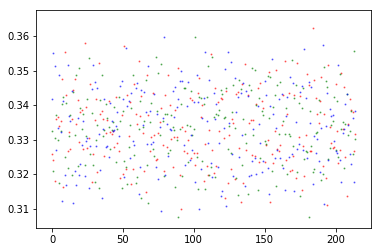

group_sc_A_tilda
 1  2  3 
86 35 94 


   pvalue 
0.8469429 


@@@@@@


group_sc_emb
  1   2   3 
 43 133  39 


    pvalue 
0.01211324 


@@@@@@@@@@@@
###############################################
Epoch: 0701 train_loss= 5.18320 recon_loss= 5.19419 fair_attention_loss= -1.09861 ortho_L_loss= 3.13341 clustering_loss= 5.96231 L1_on_view_hat= 0.00443


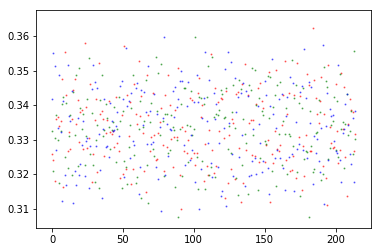

group_sc_A_tilda
 1  2  3 
86 35 94 


   pvalue 
0.8469429 


@@@@@@


group_sc_emb
  1   2   3 
133  42  40 


    pvalue 
0.01609936 


@@@@@@@@@@@@
###############################################
Epoch: 0801 train_loss= 5.18235 recon_loss= 5.19334 fair_attention_loss= -1.09861 ortho_L_loss= 3.13341 clustering_loss= 5.96231 L1_on_view_hat= 0.00443


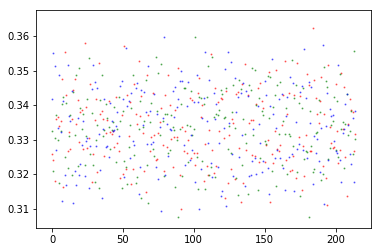

group_sc_A_tilda
 1  2  3 
86 35 94 


   pvalue 
0.8469429 


@@@@@@


group_sc_emb
  1   2   3 
 42  40 133 


    pvalue 
0.01609936 


@@@@@@@@@@@@
###############################################
Epoch: 0901 train_loss= 5.18183 recon_loss= 5.19281 fair_attention_loss= -1.09861 ortho_L_loss= 3.13341 clustering_loss= 5.96231 L1_on_view_hat= 0.00443


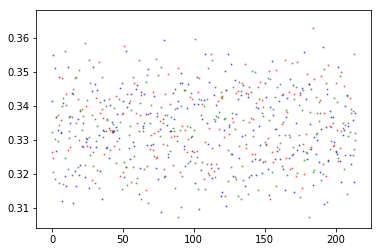

group_sc_A_tilda
 1  2  3 
86 35 94 


   pvalue 
0.8469429 


@@@@@@


group_sc_emb
  1   2   3 
 44 131  40 


    pvalue 
0.01229627 


@@@@@@@@@@@@
###############################################
Epoch: 1001 train_loss= 5.18150 recon_loss= 5.19248 fair_attention_loss= -1.09861 ortho_L_loss= 3.13341 clustering_loss= 5.96231 L1_on_view_hat= 0.00443


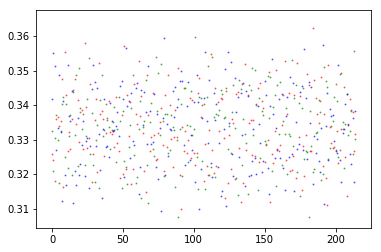

group_sc_A_tilda
 1  2  3 
86 35 94 


   pvalue 
0.8469429 


@@@@@@


group_sc_emb
  1   2   3 
 45 130  40 


     pvalue 
0.007320041 


@@@@@@@@@@@@
###############################################
Epoch: 1101 train_loss= 5.18127 recon_loss= 5.19226 fair_attention_loss= -1.09861 ortho_L_loss= 3.13341 clustering_loss= 5.96231 L1_on_view_hat= 0.00443


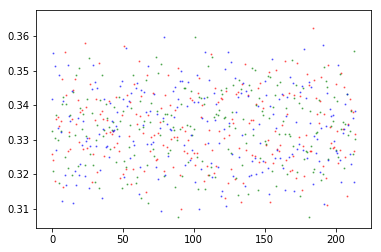

group_sc_A_tilda
 1  2  3 
86 35 94 


   pvalue 
0.8469429 


@@@@@@


group_sc_emb
  1   2   3 
 43  44 128 


    pvalue 
0.00911985 


@@@@@@@@@@@@
###############################################
Epoch: 1201 train_loss= 5.18111 recon_loss= 5.19210 fair_attention_loss= -1.09861 ortho_L_loss= 3.13341 clustering_loss= 5.96231 L1_on_view_hat= 0.00443


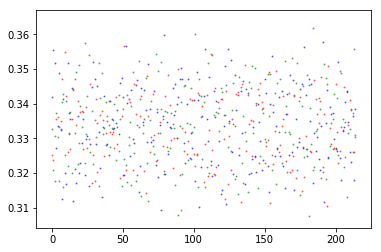

group_sc_A_tilda
 1  2  3 
86 35 94 


   pvalue 
0.8469429 


@@@@@@


group_sc_emb
  1   2   3 
128  44  43 


    pvalue 
0.00911985 


@@@@@@@@@@@@
###############################################
Epoch: 1301 train_loss= 5.18100 recon_loss= 5.19198 fair_attention_loss= -1.09861 ortho_L_loss= 3.13341 clustering_loss= 5.96231 L1_on_view_hat= 0.00443


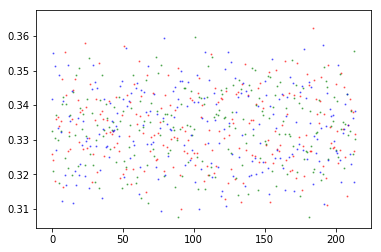

group_sc_A_tilda
 1  2  3 
86 35 94 


   pvalue 
0.8469429 


@@@@@@


group_sc_emb
  1   2   3 
 43 128  44 


    pvalue 
0.00911985 


@@@@@@@@@@@@
###############################################
Epoch: 1401 train_loss= 5.18091 recon_loss= 5.19190 fair_attention_loss= -1.09861 ortho_L_loss= 3.13341 clustering_loss= 5.96231 L1_on_view_hat= 0.00443


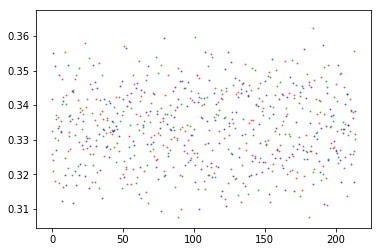

group_sc_A_tilda
 1  2  3 
86 35 94 


   pvalue 
0.8469429 


@@@@@@


group_sc_emb
  1   2   3 
 44 128  43 


    pvalue 
0.00911985 


@@@@@@@@@@@@
###############################################
Epoch: 1501 train_loss= 5.18084 recon_loss= 5.19183 fair_attention_loss= -1.09861 ortho_L_loss= 3.13341 clustering_loss= 5.96231 L1_on_view_hat= 0.00443


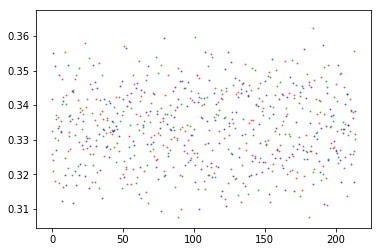

group_sc_A_tilda
 1  2  3 
86 35 94 


   pvalue 
0.8469429 


@@@@@@


group_sc_emb
  1   2   3 
 45  43 127 


     pvalue 
0.005289572 


@@@@@@@@@@@@
###############################################
Epoch: 1601 train_loss= 5.18078 recon_loss= 5.19177 fair_attention_loss= -1.09861 ortho_L_loss= 3.13341 clustering_loss= 5.96231 L1_on_view_hat= 0.00443


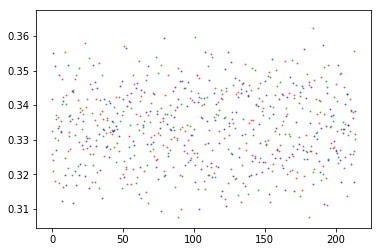

group_sc_A_tilda
 1  2  3 
86 35 94 


   pvalue 
0.8469429 


@@@@@@


group_sc_emb
  1   2   3 
 45 127  43 


     pvalue 
0.005289572 


@@@@@@@@@@@@
###############################################
Epoch: 1701 train_loss= 5.18074 recon_loss= 5.19172 fair_attention_loss= -1.09861 ortho_L_loss= 3.13341 clustering_loss= 5.96231 L1_on_view_hat= 0.00443


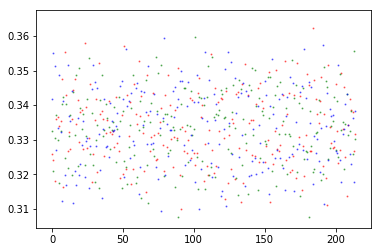

group_sc_A_tilda
 1  2  3 
86 35 94 


   pvalue 
0.8469429 


@@@@@@


group_sc_emb
  1   2   3 
127  45  43 


     pvalue 
0.005289572 


@@@@@@@@@@@@
###############################################
Epoch: 1801 train_loss= 5.18069 recon_loss= 5.19168 fair_attention_loss= -1.09861 ortho_L_loss= 3.13341 clustering_loss= 5.96231 L1_on_view_hat= 0.00443


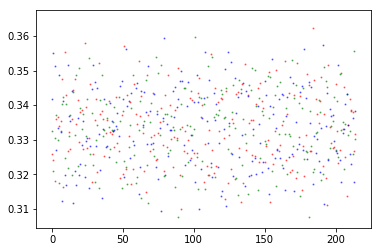

group_sc_A_tilda
 1  2  3 
86 35 94 


   pvalue 
0.8469429 


@@@@@@


group_sc_emb
  1   2   3 
127  43  45 


     pvalue 
0.005289572 


@@@@@@@@@@@@
###############################################
Epoch: 1901 train_loss= 5.18066 recon_loss= 5.19165 fair_attention_loss= -1.09861 ortho_L_loss= 3.13341 clustering_loss= 5.96231 L1_on_view_hat= 0.00443


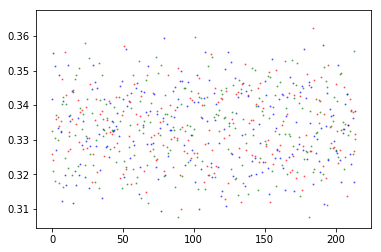

group_sc_A_tilda
 1  2  3 
86 35 94 


   pvalue 
0.8469429 


@@@@@@


group_sc_emb
  1   2   3 
 45 127  43 


     pvalue 
0.005289572 


@@@@@@@@@@@@
###############################################
Epoch: 2001 train_loss= 5.18063 recon_loss= 5.19162 fair_attention_loss= -1.09861 ortho_L_loss= 3.13341 clustering_loss= 5.96231 L1_on_view_hat= 0.00443


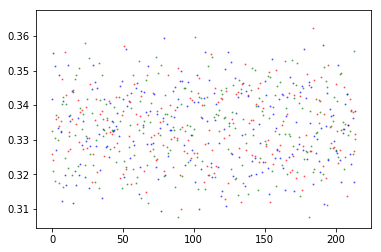

group_sc_A_tilda
 1  2  3 
86 35 94 


   pvalue 
0.8469429 


@@@@@@


group_sc_emb
  1   2   3 
 43  45 127 


     pvalue 
0.005289572 


@@@@@@@@@@@@
###############################################
Epoch: 2101 train_loss= 5.18061 recon_loss= 5.19160 fair_attention_loss= -1.09861 ortho_L_loss= 3.13341 clustering_loss= 5.96231 L1_on_view_hat= 0.00443


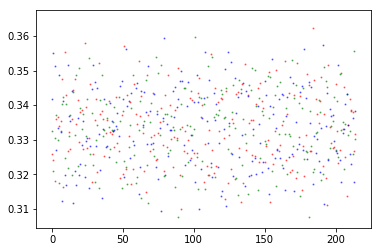

group_sc_A_tilda
 1  2  3 
86 35 94 


   pvalue 
0.8469429 


@@@@@@


group_sc_emb
  1   2   3 
127  43  45 


     pvalue 
0.005289572 


@@@@@@@@@@@@
###############################################
Epoch: 2201 train_loss= 5.18059 recon_loss= 5.19157 fair_attention_loss= -1.09861 ortho_L_loss= 3.13341 clustering_loss= 5.96231 L1_on_view_hat= 0.00443


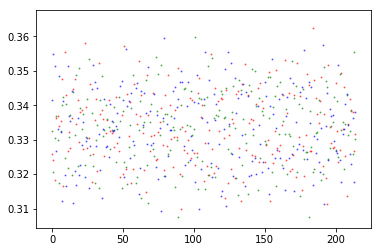

group_sc_A_tilda
 1  2  3 
86 35 94 


   pvalue 
0.8469429 


@@@@@@


group_sc_emb
  1   2   3 
 43  45 127 


     pvalue 
0.005289572 


@@@@@@@@@@@@
###############################################
Epoch: 2301 train_loss= 5.18057 recon_loss= 5.19155 fair_attention_loss= -1.09861 ortho_L_loss= 3.13341 clustering_loss= 5.96231 L1_on_view_hat= 0.00443


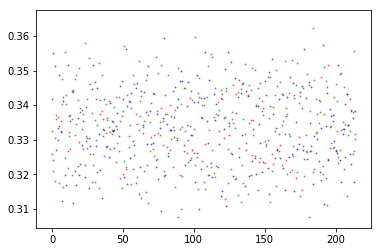

group_sc_A_tilda
 1  2  3 
86 35 94 


   pvalue 
0.8469429 


@@@@@@


group_sc_emb
  1   2   3 
 43 127  45 


     pvalue 
0.005289572 


@@@@@@@@@@@@
###############################################
Epoch: 2401 train_loss= 5.18055 recon_loss= 5.19153 fair_attention_loss= -1.09861 ortho_L_loss= 3.13341 clustering_loss= 5.96231 L1_on_view_hat= 0.00443


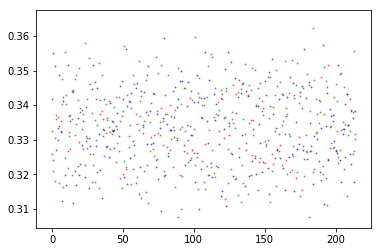

group_sc_A_tilda
 1  2  3 
86 35 94 


   pvalue 
0.8469429 


@@@@@@


group_sc_emb
  1   2   3 
 45  43 127 


     pvalue 
0.005289572 


@@@@@@@@@@@@
###############################################
Epoch: 2501 train_loss= 5.18053 recon_loss= 5.19152 fair_attention_loss= -1.09861 ortho_L_loss= 3.13341 clustering_loss= 5.96231 L1_on_view_hat= 0.00443


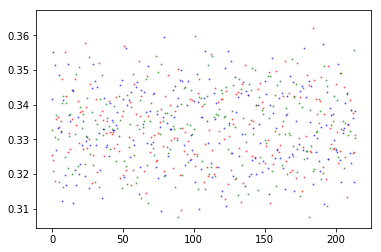

group_sc_A_tilda
 1  2  3 
86 35 94 


   pvalue 
0.8469429 


@@@@@@


group_sc_emb
  1   2   3 
127  45  43 


     pvalue 
0.005289572 


@@@@@@@@@@@@
###############################################
Epoch: 2601 train_loss= 5.18051 recon_loss= 5.19150 fair_attention_loss= -1.09861 ortho_L_loss= 3.13341 clustering_loss= 5.96231 L1_on_view_hat= 0.00443


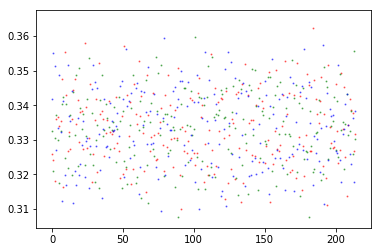

group_sc_A_tilda
 1  2  3 
86 35 94 


   pvalue 
0.8469429 


@@@@@@


group_sc_emb
  1   2   3 
127  45  43 


     pvalue 
0.005289572 


@@@@@@@@@@@@
###############################################


KeyboardInterrupt: ignored

In [ ]:
#Training Cell  LBFGS
#optimzier_type = 'lbfgs'
optimzier_type = 'adam'

my_model = Model(optimzier_type,torch.Tensor(get_nomralized_laplacian(W_gene)),torch.Tensor(get_nomralized_laplacian(W_methy)),torch.Tensor(get_nomralized_laplacian(W_mirna)))

train_features_tensor = torch.Tensor(np.identity(215))

for epoch_counter in range(10000):

  
  
  
  if optimzier_type=='lbfgs':
    my_model.backprop2(train_features_tensor)
  elif optimzier_type=='adam':
    my_model.forward(train_features_tensor)
    my_model.backprop()

  if epoch_counter % 100 ==0:
      loss,recon_loss,fair_attention_loss,ortho_L_loss,clustering_loss,L1_on_view_hat = my_model.forward(train_features_tensor)
      print("Epoch:", '%04d' % (epoch_counter + 1), "train_loss=", "{:.5f}".format(loss), "recon_loss=", "{:.5f}".format(recon_loss), "fair_attention_loss=", "{:.5f}".format(fair_attention_loss), "ortho_L_loss=", "{:.5f}".format(ortho_L_loss), "clustering_loss=", "{:.5f}".format(clustering_loss), "L1_on_view_hat=", "{:.5f}".format(L1_on_view_hat))
      plt.scatter(x=range(215), y=torch.Tensor(my_model.g_gene).detach().numpy(), s=1, c= 'red', alpha=0.5)
      plt.scatter(x=range(215), y=torch.Tensor(my_model.g_methy).detach().numpy(), s=1, c= 'green', alpha=0.5)
      plt.scatter(x=range(215), y=torch.Tensor(my_model.g_mirna).detach().numpy(), s=1, c= 'blue', alpha=0.5)
      plt.show()
      
      A_tilda = torch.Tensor(my_model.view_hat).detach().numpy()
      A_tilda_intermediate = ro.r.matrix(A_tilda, nrow=A_tilda.shape[0], ncol=A_tilda.shape[1])
      ro.r.assign("A_tilda", A_tilda_intermediate)
      %R group_sc_A_tilda <- NL_spectralClustering(A_tilda, K=3, type = 3) 
      %R print(table(group_sc_A_tilda))
      %R print(get_cox_pvalue(group_sc_A_tilda)[[9]][3])
      print("@@@@@@")
      emb = torch.Tensor(my_model.layer_1).detach().numpy()
      emb_intermediate = ro.r.matrix(emb, nrow=emb.shape[0], ncol=emb.shape[1])
      ro.r.assign("emb", emb_intermediate)
      %R group_sc_emb <- kmeans(emb, 3, nstart = 25)$cluster 
      %R print(table(group_sc_emb))
      %R print(get_cox_pvalue(group_sc_emb)[[9]][3])
      print("@@@@@@@@@@@@")
      # %R Dist_emb = dist2(as.matrix(emb),as.matrix(emb))
      # %R W_emb = custom_affinity_matrix(Dist_emb, K=20, 1300)
      # %R group_sc_W_emb = spectralClustering(W_emb,3, type = 3)
      # %R print(table(group_sc_W_emb))
      # %R print(get_cox_pvalue(group_sc_W_emb)[[9]][3])
      print("###############################################")


print('\n',"#########################################################",'\n')






In [ ]:
#my_model.forward(train_features_tensor)
#print((torch.abs(my_model.x_prim-train_features_tensor)).sum(1).mean(0))
print(my_model.layer_1.shape)
print(my_model.layer_2.shape)
print(my_model.layer_2[0:7,0:7])
print(torch.abs(my_model.x_prim-train_features_tensor).sum(1).mean(0))

torch.Size([215, 10])
torch.Size([215, 215])
tensor([[9.9985e-01, 8.2313e-06, 3.4610e-15, 8.6199e-06, 1.7631e-07, 0.0000e+00,
         5.3301e-32],
        [2.6683e-05, 9.9976e-01, 2.4150e-13, 1.0792e-04, 3.2480e-08, 0.0000e+00,
         4.4461e-20],
        [5.6396e-20, 1.8818e-25, 9.9993e-01, 9.9341e-08, 2.0671e-07, 3.9182e-35,
         2.6782e-07],
        [3.5054e-05, 2.1020e-04, 8.0365e-08, 9.9860e-01, 1.2415e-04, 0.0000e+00,
         6.0303e-15],
        [1.5615e-08, 9.8857e-11, 1.1805e-05, 3.9773e-05, 9.9986e-01, 1.3149e-39,
         1.5278e-14],
        [5.1710e-17, 1.5841e-23, 4.0194e-12, 1.2740e-13, 5.1746e-13, 9.9958e-01,
         6.5252e-22],
        [1.5537e-09, 2.0073e-08, 8.9693e-07, 8.5286e-08, 1.0689e-07, 2.4470e-20,
         9.9964e-01]], grad_fn=<SliceBackward>)
tensor(0.9495, grad_fn=<MeanBackward2>)


In [ ]:
%R cluster_num <-9
%R group_sc_emb <- kmeans(emb, cluster_num, nstart = 25)$cluster 
%R print(table(group_sc_emb))
%R print(get_cox_pvalue(group_sc_emb)[[9]][3])
%R group_sc_A_tilda <- NL_spectralClustering(A_tilda, cluster_num, type = 3) 
%R print(table(group_sc_A_tilda))
%R print(get_cox_pvalue(group_sc_A_tilda)[[9]][3])

group_sc_emb
 1  2  3  4  5  6  7  8  9 
15 16 17 18 22 20 10 45 52 


   pvalue 
0.2927874 


group_sc_A_tilda
 1  2  3  4  5  6  7  8  9 
63  8 33 14 17 30 19 20 11 


   pvalue 
0.3737221 


In [ ]:
my_model.forward(train_features_tensor)
#print(my_model.x_prim)

permutation = np.arange(215)
np.random.shuffle(permutation)
permuted_i = np.zeros((215,215))
for i in range(215):
  permuted_i[i,permutation[i]]=1
permuted_i_tensor = torch.Tensor(permuted_i)
my_model.forward(permuted_i_tensor)
permuted_i_response_tensor = my_model.layer_2

compare_tensor = (np.c_[torch.nonzero(permuted_i_tensor)[:,1].numpy(),permuted_i_response_tensor.argmax(1).numpy()])
print(np.abs(compare_tensor[:,0]-compare_tensor[:,1]).sum())
#print()

12580


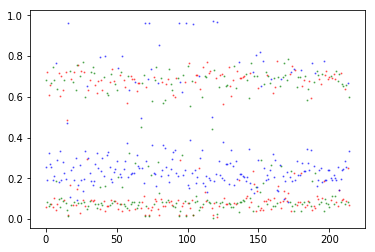

In [ ]:
#print(my_model.g_gene)
#print(my_model.g_mirna)
plt.scatter(x=range(215), y=my_model.g_gene.detach().numpy(), s=1, c= 'red', alpha=0.5)
plt.scatter(x=range(215), y=my_model.g_methy.detach().numpy(), s=1, c= 'green', alpha=0.5)
plt.scatter(x=range(215), y=my_model.g_mirna.detach().numpy(), s=1, c= 'blue', alpha=0.5)

#print(my_model.A_tilda_gene)
#print(W_gene[range(215),range(215)])
#print(W_methy[range(215),range(215)])
#print(W_mirna[range(215),range(215)])

#print(my_model.A_tilda_gene)
#ordx = np.argsort(my_model.g_gene.detach().numpy())
#ordxx = ordx[0:150]
#ordxxx = ordx[150:215]
#plt.scatter(x=range(215), y=my_model.g_gene.detach().numpy(), s=1, c= 0.1*np.ones(215), alpha=0.5)
#plt.scatter(x=range(215), y=my_model.g_mirna.detach().numpy()[ordx], s=1, c= 0.1*np.ones(215), alpha=0.5)
#print(np.c_[my_model.g_gene.detach().numpy()[ordx],np.array(range(215))])
#print(truelabel[:,1][ordxx].mean())
#print(truelabel[:,1][ordxxx].mean())
#print()
#plt.scatter(x=range(215), y=my_model.g_gene.detach().numpy(), s=1, c= 0.1*np.ones(215), alpha=0.5)
#plt.scatter(x=range(215), y=my_model.g_methy.detach().numpy(), s=1, c= 0.4*np.ones(215), alpha=0.5)
#plt.scatter(x=range(215), y=my_model.g_mirna.detach().numpy(), s=1, c= 0.9*np.ones(215), alpha=0.5)
plt.show()


In [ ]:

#np.savetxt("/content/drive/My Drive/Data Fusion/results/W_v51.txt",my_model.A_tilda_hat.detach().numpy(),delimiter='\t')
#np.savetxt("/content/drive/My Drive/Data Fusion/results/emb_v50.txt",my_model.embedding.detach().numpy(),delimiter='\t')
#print(my_model.A_tilda_hat.detach().numpy())

In [ ]:
my_model.forward(train_features_tensor)
emb = my_model.embedding.detach().numpy()
np.savetxt("/content/drive/My Drive/Data Fusion/results/emb_v21.txt",emb,delimiter='\t')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
print(W_gene[0:5,0:5])

[[2.20250988e-05 1.23456250e-05 7.98397838e-06 8.33432746e-06
  8.13768903e-06]
 [1.23456250e-05 2.79446012e-05 5.99251221e-06 1.14434393e-05
  8.52149002e-06]
 [7.98397838e-06 5.99251221e-06 1.60516449e-05 6.20174722e-06
  7.64236148e-06]
 [8.33432746e-06 1.14434393e-05 6.20174722e-06 2.16228805e-05
  7.77526885e-06]
 [8.13768903e-06 8.52149002e-06 7.64236148e-06 7.77526885e-06
  1.99531018e-05]]


In [ ]:
%%R
print(W_gene[0:5,0:5])
print(W_methy[0:5,0:5])
print(W_mirna[0:5,0:5])
r.
#print(Dist_gene[0:5,0:5])


              V2            V3            V4            V5            V6
V2  3.068787e-04  3.187392e-51 7.611139e-122 3.026863e-112 1.089196e-117
V3  3.187392e-51  3.068787e-04 4.930383e-199  2.041452e-60 5.391200e-107
V4 7.611139e-122 4.930383e-199  3.068787e-04 8.882017e-195 1.315769e-132
V5 3.026863e-112  2.041452e-60 8.882017e-195  3.068787e-04 4.503802e-128
V6 1.089196e-117 5.391200e-107 1.315769e-132 4.503802e-128  3.068787e-04
             V2           V3           V4           V5           V6
V2 3.068787e-04 1.232209e-04 5.839313e-05 1.308644e-04 7.176845e-05
V3 1.232209e-04 3.068787e-04 6.562024e-05 1.043658e-04 4.488297e-05
V4 5.839313e-05 6.562024e-05 3.068787e-04 1.055716e-04 1.602596e-05
V5 1.308644e-04 1.043658e-04 1.055716e-04 3.068787e-04 4.092852e-05
V6 7.176845e-05 4.488297e-05 1.602596e-05 4.092852e-05 3.068787e-04
             V2           V3           V4           V5           V6
V2 0.0003068787 0.0002558803 0.0002380599 0.0002286589 0.0002155245
V3 0.0002558803 0.

In [ ]:
print(np.array(ro.r['W_gene']).shape)

(215, 215)


In [ ]:
%%R

	

# install.packages("SNFtool")
# install.packages("data.table")
# install.packages("survival")
# install.packages("survminer")
# install.packages("mltools")

#install.packages("dplyr")
#install.packages("pheatmap")
#install.packages("factoextra")
#install.packages("gplots")
#library(gplots)
#install.packages("ggplot2")


library(SNFtool)
library(data.table)
library(survival)
library(survminer)
library(mltools)
# library(dplyr)
# library(pheatmap)
# library(factoextra)
# library(ggplot2)









In [ ]:
%%R
NL_spectralClustering <- function (NL, K, type = 3) 
{
	eig <- eigen(NL)
	res <- sort(abs(eig$values), index.return = TRUE)
	U <- eig$vectors[, res$ix[1:K]]
	normalize <- function(x) x/sqrt(sum(x^2))
	if (type == 3) {
		U <- t(apply(U, 1, normalize))
	}     
	
	eigDiscrete <- SNFtool:::.discretisation(U)
	eigDiscrete <- eigDiscrete$discrete
	labels <- apply(eigDiscrete, 1, which.max)
	return(labels)
}

get_cox_pvalue<-function(group){
  one_hot_group <- matrix(0, 215, max(group))
  for (i in 1:215){
    one_hot_group[i,group[i]]<-1
  }
  tt<-coxph(Surv( survival,censor ) ~ one_hot_group)
  return(summary(tt))
}

get_cox_pvalue2<-function(group){
  tt<-coxph(Surv( survival,censor ) ~ group)
  return(summary(tt))
}

custom_affinity_matrix <- function (diff, K = 20, sigma = 0.5) 
{
	N <- nrow(diff)
	diff <- (diff + t(diff))/2
	diag(diff) <- 0
	sortedColumns <- as.matrix(t(apply(diff, 2, sort)))
	finiteMean <- function(x) {
		return(mean(x[is.finite(x)]))
	}
	means <- apply(sortedColumns[, 1:K + 1], 1, finiteMean) + 
		.Machine$double.eps
	avg <- function(x, y) {
		return((x + y)/2)
	}
	Sig <- outer(means, means, avg)/3 * 2 + diff/3 + .Machine$double.eps
	Sig[Sig <= .Machine$double.eps] <- .Machine$double.eps
	#print(Sig)
  Sig <- matrix(1, 215, 215)
  densities <- dnorm(diff, 0, sigma * Sig, log = FALSE)
	W <- (densities + t(densities))/2
	return(W)
}

In [ ]:

import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()


survival_intermediate = ro.r.matrix(truelabel[:,1], nrow=215, ncol=1)
ro.r.assign("survival", survival_intermediate)

censor_intermediate = ro.r.matrix(truelabel[:,2], nrow=215, ncol=1)
ro.r.assign("censor", censor_intermediate)

%R survival <- as.numeric(survival)
%R censor <- as.numeric(censor)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
%%R

##40 ,3 
###20 0.6
####30 0.3
K = 20;##number of neighbors, usually (10~30)
alpha = 1500 ##hyperparameter, usually (0.3~0.8)
T = 17; ###Number of Iterations, usually (10~20)
C = 3###number of clusters
use.corr <- F


gene <- data.matrix(fread("/content/drive/My Drive/Data Fusion/GBM/GLIO_Gene_Expression.txt", header = F, sep = "\t", dec = ".")[,2:216])
methy <- data.matrix(fread("/content/drive/My Drive/Data Fusion/GBM/GLIO_Methy_Expression.txt", header = F, sep = "\t", dec = ".")[,2:216])
mirna <- data.matrix(fread("/content/drive/My Drive/Data Fusion/GBM/GLIO_Mirna_Expression.txt", header = F, sep = "\t", dec = ".")[,2:216])
survival <- data.matrix(fread("/content/drive/My Drive/Data Fusion/GBM/GLIO_Survival.txt", header = F, sep = "\t", dec = ".")[-1,2])
censor <- data.matrix(fread("/content/drive/My Drive/Data Fusion/GBM/GLIO_Survival.txt", header = F, sep = "\t", dec = ".")[-1,3])



gene = t(gene)
methy = t(methy)
mirna = t(mirna)


methy = standardNormalization(methy);
gene = standardNormalization(gene);
mirna = standardNormalization(mirna);

Dist_methy = dist2(as.matrix(methy),as.matrix(methy));
Dist_gene = dist2(as.matrix(gene),as.matrix(gene));
Dist_mirna = dist2(as.matrix(mirna),as.matrix(mirna));

W_methy = custom_affinity_matrix(Dist_methy, K, 1000)
W_gene = custom_affinity_matrix(Dist_gene, K, 10000)
W_mirna = custom_affinity_matrix(Dist_mirna, K, 400)




In [ ]:
%%R
#W_gene[0:5,0:5]
#W_mirna[0:5,0:5]
W_methy[0:5,0:5]

             V2           V3           V4           V5           V6
V2 3.989423e-04 8.534791e-05 2.415948e-05 9.448544e-05 3.423450e-05
V3 8.534791e-05 3.989423e-04 2.942593e-05 6.446143e-05 1.548653e-05
V4 2.415948e-05 2.942593e-05 3.989423e-04 6.572502e-05 2.716997e-06
V5 9.448544e-05 6.446143e-05 6.572502e-05 3.989423e-04 1.325136e-05
V6 3.423450e-05 1.548653e-05 2.716997e-06 1.325136e-05 3.989423e-04
